Using device: cuda
Boston dataset load failed: 
`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
   

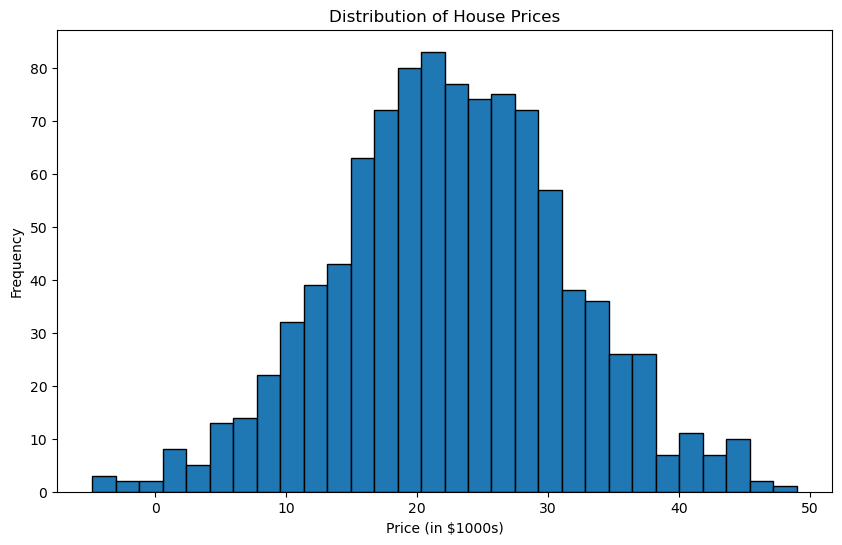

Training set size: 800
Test set size: 200
HousePriceModel(
  (fc1): Linear(in_features=13, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)
Starting training...
Epoch [50/500], Train Loss: 0.7662, Test Loss: 1.0611
Epoch [100/500], Train Loss: 0.6788, Test Loss: 1.1739
Epoch [150/500], Train Loss: 0.5587, Test Loss: 1.2186
Epoch [200/500], Train Loss: 0.5222, Test Loss: 1.2615
Epoch [250/500], Train Loss: 0.4868, Test Loss: 1.2563
Epoch [300/500], Train Loss: 0.4766, Test Loss: 1.2643
Epoch [350/500], Train Loss: 0.4336, Test Loss: 1.2653
Epoch [400/500], Train Loss: 0.4256, Test Loss: 1.2503
Epoch [450/500], Train Loss: 0.3695, Test Loss: 1.2596
Epoch [500/500], Train Loss: 0.3715, Test Loss: 1.2777
Training completed!


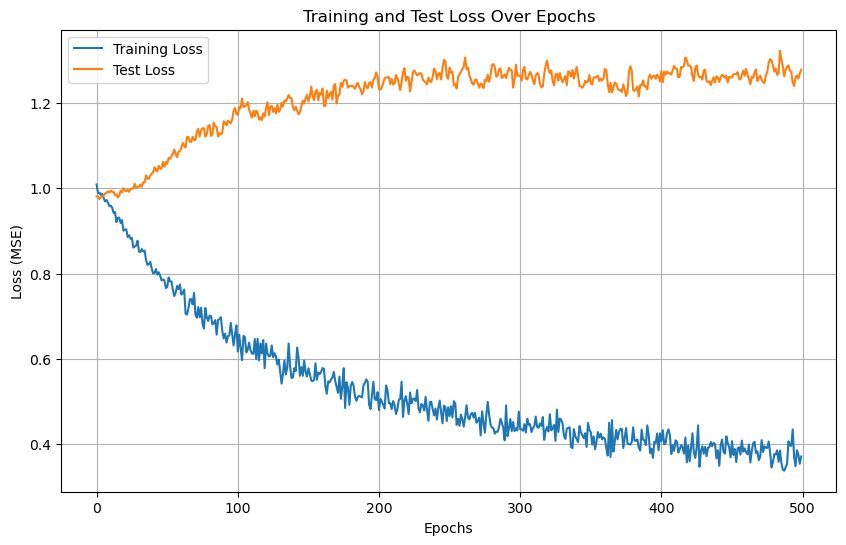

Mean Absolute Error: $7774.37
Root Mean Squared Error: $10121.84
R² Score: -0.3225


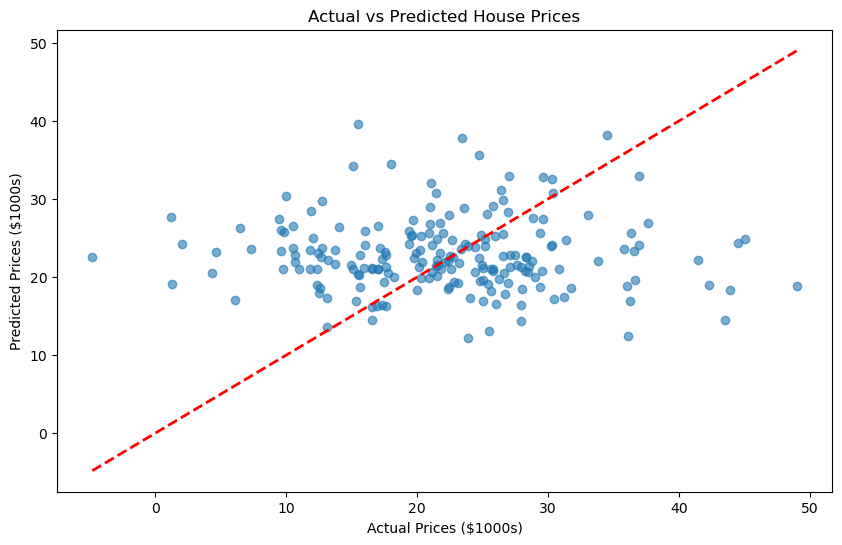

Model and scalers saved successfully!
Example House Features:
CRIM: 0.02731
ZN: 0.0
INDUS: 7.07
CHAS: 0
NOX: 0.469
RM: 6.421
AGE: 78.9
DIS: 4.9671
RAD: 2
TAX: 242
PTRATIO: 17.8
B: 396.9
LSTAT: 9.14

Predicted Price: $16731.89
API file created: house_price_api.py
To run the API, execute: python house_price_api.py
Testing prediction function with multiple examples:
Example 1: $16731.89
Example 2: $14461.53
Example 3: $14382.00


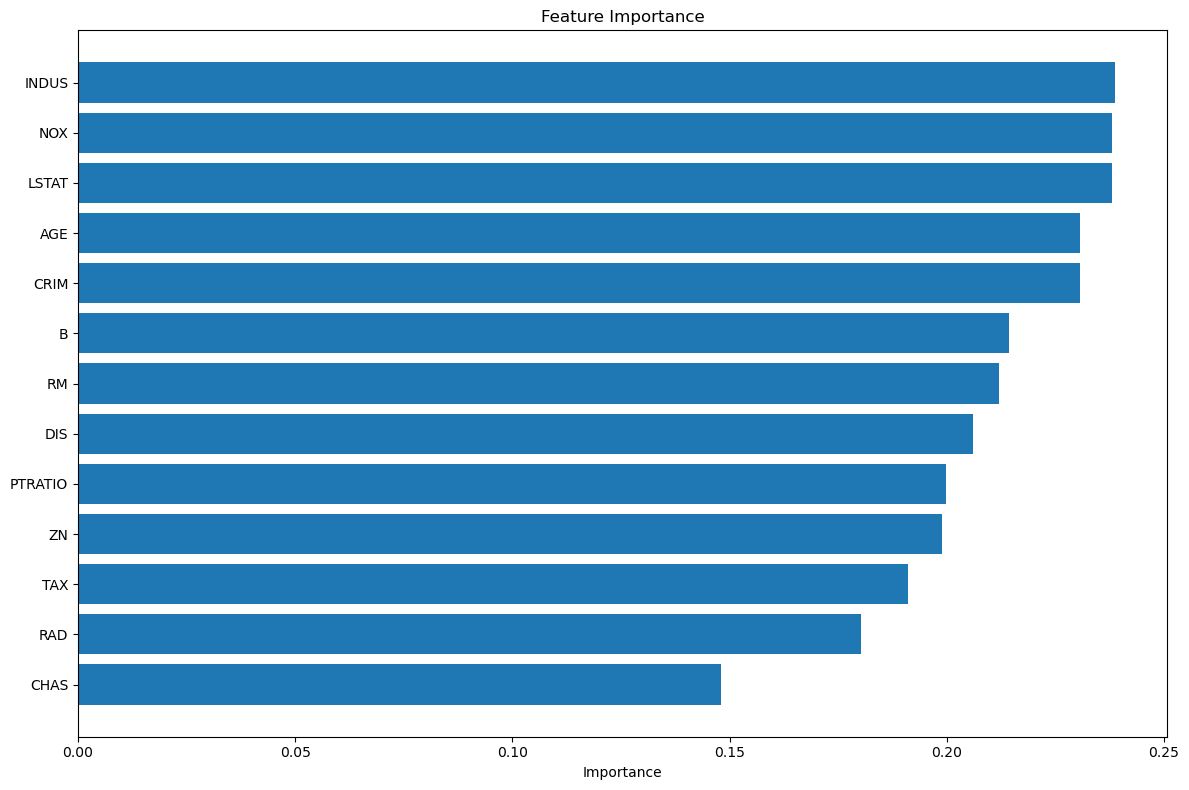

Notebook execution completed!
To run the Flask API, execute: python house_price_api.py


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def fetch_housing_data():
    try:
        from sklearn.datasets import load_boston
        boston = load_boston()
        df = pd.DataFrame(boston.data, columns=boston.feature_names)
        df['PRICE'] = boston.target
        print("Data successfully loaded")
        return df
    except Exception as e:
        print(f"Boston dataset load failed: {e}. Using fallback dataset...")
        print("Creating synthetic data...")
        np.random.seed(42)
        n_samples = 1000
        data = {
            'CRIM': np.random.exponential(1, n_samples),
            'ZN': np.random.choice([0, 12.5, 25, 37.5, 50, 75, 100], n_samples),
            'INDUS': np.random.normal(11, 7, n_samples),
            'CHAS': np.random.choice([0, 1], n_samples, p=[0.94, 0.06]),
            'NOX': np.random.normal(0.55, 0.12, n_samples),
            'RM': np.random.normal(6.3, 0.7, n_samples),
            'AGE': np.random.normal(68.5, 28, n_samples),
            'DIS': np.random.exponential(3.8, n_samples),
            'RAD': np.random.choice([1, 2, 3, 4, 5, 6, 7, 8, 24], n_samples),
            'TAX': np.random.normal(408, 168, n_samples),
            'PTRATIO': np.random.normal(18.5, 2.1, n_samples),
            'B': np.random.normal(356, 91, n_samples),
            'LSTAT': np.random.normal(12.7, 7.1, n_samples),
            'PRICE': np.random.normal(22.5, 9, n_samples)
        }
        df = pd.DataFrame(data)
        return df

housing_data = fetch_housing_data()
print(housing_data.head())
print(f"Dataset shape: {housing_data.shape}")

plt.figure(figsize=(10, 6))
plt.hist(housing_data['PRICE'], bins=30, edgecolor='black')
plt.title('Distribution of House Prices')
plt.xlabel('Price (in $1000s)')
plt.ylabel('Frequency')
plt.show()

X = housing_data.drop('PRICE', axis=1).values
y = housing_data['PRICE'].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

print(f"Training set size: {X_train_tensor.shape[0]}")
print(f"Test set size: {X_test_tensor.shape[0]}")

class HousePriceModel(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32, output_size=1):
        super(HousePriceModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out

input_size = X_train.shape[1]
model = HousePriceModel(input_size).to(device)
print(model)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

num_epochs = 500
train_losses = []
test_losses = []

print("Starting training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    model.eval()
    with torch.no_grad():
        X_test_tensor_device = X_test_tensor.to(device)
        y_test_tensor_device = y_test_tensor.to(device)
        test_outputs = model(X_test_tensor_device)
        test_loss = criterion(test_outputs, y_test_tensor_device)
        test_losses.append(test_loss.item())
    
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {test_loss.item():.4f}')

print("Training completed!")

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

model.eval()
with torch.no_grad():
    X_test_tensor_device = X_test_tensor.to(device)
    predictions_scaled = model(X_test_tensor_device)
    predictions = scaler_y.inverse_transform(predictions_scaled.cpu().numpy())
    actual = scaler_y.inverse_transform(y_test_scaled)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(actual, predictions)
mse = mean_squared_error(actual, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(actual, predictions)

print(f"Mean Absolute Error: ${mae*1000:.2f}")
print(f"Root Mean Squared Error: ${rmse*1000:.2f}")
print(f"R² Score: {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(actual, predictions, alpha=0.6)
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', lw=2)
plt.xlabel('Actual Prices ($1000s)')
plt.ylabel('Predicted Prices ($1000s)')
plt.title('Actual vs Predicted House Prices')
plt.show()

torch.save(model.state_dict(), 'house_price_model.pth')
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')
print("Model and scalers saved successfully!")

def predict_house_price(features):
    model = HousePriceModel(input_size).to(device)
    model.load_state_dict(torch.load('house_price_model.pth', map_location=device))
    model.eval()
    
    scaler_X = joblib.load('scaler_X.pkl')
    scaler_y = joblib.load('scaler_y.pkl')
    
    features_array = np.array(features).reshape(1, -1)
    features_scaled = scaler_X.transform(features_array)
    features_tensor = torch.tensor(features_scaled, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        prediction_scaled = model(features_tensor)
        prediction = scaler_y.inverse_transform(prediction_scaled.cpu().numpy())
    
    return prediction[0][0]

example_features = [0.02731, 0.0, 7.07, 0, 0.469, 6.421, 78.9, 4.9671, 2, 242, 17.8, 396.90, 9.14]
predicted_price = predict_house_price(example_features)

print("Example House Features:")
feature_names = housing_data.columns.drop('PRICE').tolist()
for feature, value in zip(feature_names, example_features):
    print(f"{feature}: {value}")

print(f"\nPredicted Price: ${predicted_price*1000:.2f}")

api_code = '''
import torch
import numpy as np
from flask import Flask, request, jsonify
import joblib

app = Flask(__name__)

class HousePriceModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32, output_size=1):
        super(HousePriceModel, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size1)
        self.fc2 = torch.nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = torch.nn.Linear(hidden_size2, output_size)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.2)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 13

model = HousePriceModel(input_size).to(device)
model.load_state_dict(torch.load('house_price_model.pth', map_location=device))
model.eval()

scaler_X = joblib.load('scaler_X.pkl')
scaler_y = joblib.load('scaler_y.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    try:
        data = request.get_json()
        features = np.array(data['features']).reshape(1, -1)
        features_scaled = scaler_X.transform(features)
        features_tensor = torch.tensor(features_scaled, dtype=torch.float32).to(device)
        
        with torch.no_grad():
            prediction_scaled = model(features_tensor)
            prediction = scaler_y.inverse_transform(prediction_scaled.cpu().numpy())
        
        return jsonify({
            'prediction': prediction[0][0],
            'status': 'success'
        })
    
    except Exception as e:
        return jsonify({
            'error': str(e),
            'status': 'error'
        }), 400

@app.route('/health', methods=['GET'])
def health():
    return jsonify({'status': 'healthy'})

if __name__ == '__main__':
    app.run(debug=True, host='0.0.0.0', port=5000)
'''

with open('house_price_api.py', 'w') as f:
    f.write(api_code)

print("API file created: house_price_api.py")
print("To run the API, execute: python house_price_api.py")

test_examples = [
    [0.02731, 0.0, 7.07, 0, 0.469, 6.421, 78.9, 4.9671, 2, 242, 17.8, 396.90, 9.14],
    [0.03237, 0.0, 2.18, 0, 0.458, 6.998, 45.8, 6.0622, 3, 222, 18.7, 394.63, 2.94],
    [0.06905, 0.0, 2.18, 0, 0.458, 7.147, 54.2, 6.0622, 3, 222, 18.7, 396.90, 5.33]
]

print("Testing prediction function with multiple examples:")
for i, example in enumerate(test_examples):
    predicted_price = predict_house_price(example)
    print(f"Example {i+1}: ${predicted_price*1000:.2f}")

model.eval()
with torch.no_grad():
    weights = model.fc1.weight.data.cpu().numpy()
    feature_importance = np.mean(np.abs(weights), axis=0)
    
    importance_df = pd.DataFrame({
        'feature': housing_data.columns.drop('PRICE').tolist(),
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Notebook execution completed!")
print("To run the Flask API, execute: python house_price_api.py")